In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import stft, resample
from python_speech_features import mfcc
from keras.models import load_model
import numpy as np
import pyaudio

In [61]:
%matplotlib inline

In [62]:
# !pip install --upgrade pip
# !pip install pyalsaaudio pyaudio
# !pip install python_speech_features
# !pip install librosa

In [63]:
sampling_rate = 16_000

In [64]:
p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    print("name: %(name)s channels(o,i): %(maxOutputChannels)s %(maxInputChannels)s"%p.get_device_info_by_host_api_device_index(0,i))

stream = p.open(rate=sampling_rate, channels=1, format=pyaudio.paFloat32, input=True, output=True)

name: HDA Intel PCH: ALC3234 Analog (hw:0,0) channels(o,i): 2 2
name: HDA Intel PCH: HDMI 0 (hw:0,3) channels(o,i): 8 0
name: HDA Intel PCH: HDMI 1 (hw:0,7) channels(o,i): 8 0
name: HDA Intel PCH: HDMI 2 (hw:0,8) channels(o,i): 8 0
name: Loopback: PCM (hw:1,0) channels(o,i): 32 32
name: Loopback: PCM (hw:1,1) channels(o,i): 32 32
name: sysdefault channels(o,i): 128 128
name: front channels(o,i): 2 0
name: surround40 channels(o,i): 2 0
name: surround51 channels(o,i): 2 0
name: surround71 channels(o,i): 2 0
name: hdmi channels(o,i): 8 0
name: pipewire channels(o,i): 64 64
name: dmix channels(o,i): 2 0
name: default channels(o,i): 64 64


In [65]:
%%time
duration = 5

CPU times: user 15 μs, sys: 4 μs, total: 19 μs
Wall time: 33.4 μs


In [66]:
from tqdm.notebook import tqdm
audio_buffer = bytearray()
steps = duration/100
chunks = int(steps*sampling_rate)
print("Recording Audio")
for i in tqdm(np.arange(0, duration, steps), total=100):
    audio_buffer.extend(stream.read(chunks))
print("recording finished")
stream.write(bytes(audio_buffer))

Recording Audio


  0%|          | 0/100 [00:00<?, ?it/s]

recording finished


In [97]:
time_domain = np.arange(0,duration, 1/sampling_rate)
signal = np.frombuffer(audio_buffer, dtype=np.float32)

In [98]:
preemp = np.append(signal[0], signal[:-1] - signal[1:])
fft_sig = np.fft.fft(preemp)
freq = np.fft.fftfreq(len(fft_sig), 1/sampling_rate)

In [108]:
freq_cc, time, mag = stft(signal, fs=sampling_rate, nperseg=256)

In [109]:
signal_mfcc = mfcc(signal, sampling_rate, nfilt=26, numcep=13, winlen=512/sampling_rate, winstep=256/sampling_rate)
signal_mfcc.shape

(312, 13)

In [110]:
model = load_model('analysis_mono.h5')

In [102]:
%%time
print("Prediction started")
results = []
for t_mfcc in signal_mfcc:
    results.append(model.predict(np.array([[t_mfcc]]), verbose=False)[0][0])
print("prediction finished")

Prediction started
prediction finished
CPU times: user 20 s, sys: 432 ms, total: 20.4 s
Wall time: 20 s


In [103]:
results = np.array(results)

In [104]:
# results = np.array(results)
final = results > 0.5
final_result = final.astype(np.short)

In [111]:
final_result
padded_result = []
for index, result in enumerate(final_result):
    padded_result.extend([result]*256)
len(padded_result)
padded_result.extend([final_result[-1]]*(max(0, duration*sampling_rate - len(padded_result))))

In [112]:
len(padded_result)

80000

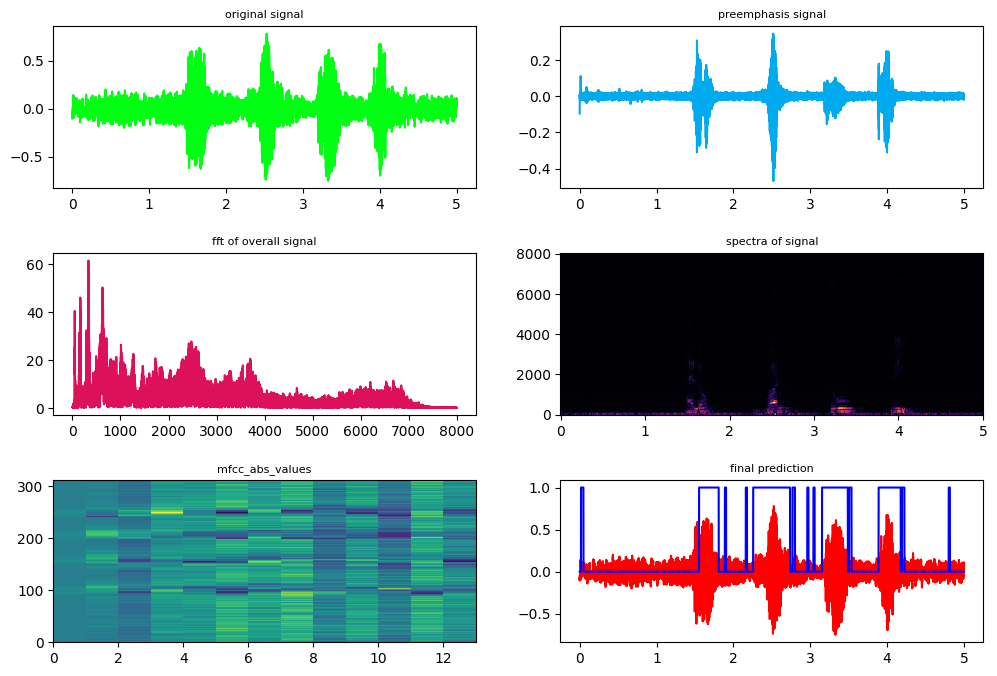

In [117]:
fig, axes = plt.subplots(3,2, figsize=(12,8))
fig.figsize = (12,8)
axes[0,0].set_title('original signal', fontsize=8)
axes[0,0].plot(np.arange(0, duration, 1/sampling_rate), signal, color='#00ff12')
axes[0,1].set_title('preemphasis signal', fontsize=8)
axes[0,1].plot(np.arange(0, duration, 1/sampling_rate), preemp, color='#00aaee')
axes[1,0].set_title('fft of overall signal', fontsize=8)
axes[1,0].plot(freq[:len(freq)//2], np.abs(fft_sig[:len(freq)//2]), color='#dd115a')
axes[1,1].set_title('spectra of signal', fontsize=8)
axes[1,1].pcolormesh(time, freq_cc, np.abs(mag), cmap='inferno')
plt.subplots_adjust(hspace=0.4)
axes[2,0].set_title('mfcc_abs_values', fontsize=8)
axes[2,0].pcolormesh(signal_mfcc)
axes[2,1].set_title('final prediction', fontsize=8)
axes[2,1].plot(np.arange(0, duration, 1/sampling_rate), signal, color='r')
axes[2,1].plot(np.arange(0, duration, 1/sampling_rate), padded_result, color='blue')

# axes[1,0].plot(freq[:len(freq)//2], np.abs(fft_sig[:len(freq)//2]), color='#aa3466')

In [ ]:
k = np.fft.fft(signal)
mag = np.abs(k)
plt.plot(mag)

In [257]:
preem = signal[:-1] - signal[1:]

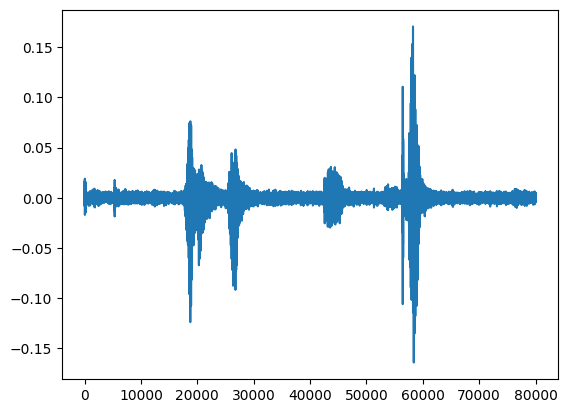

In [258]:
plt.plot(preem)

In [261]:
freq, time, mag = stft(preem, fs=sampling_rate, nperseg=256)

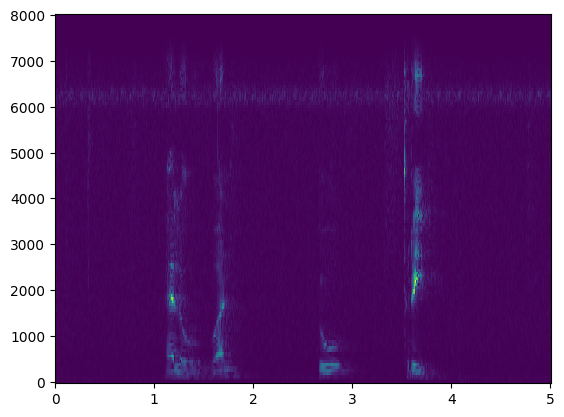

In [262]:
plt.pcolormesh(time, freq, np.abs(mag))


In [263]:
energy = np.abs(mag)**2
avg = np.sum(energy, axis=0)/energy.shape[0]

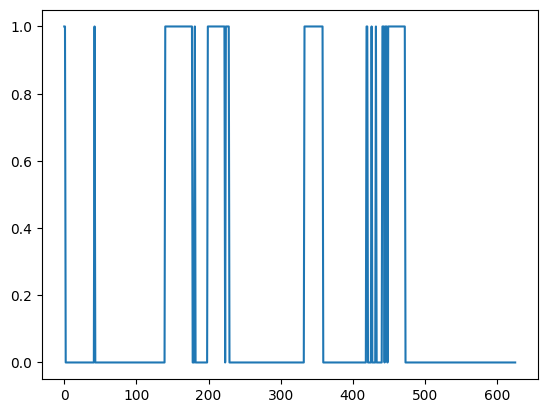

In [266]:
plt.plot(avg > 1e-7)